### Librerías

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LogisticRegression

import xgboost

import os
from datetime import date
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# Librerías propias
import py_funs
import stats_funs
import ml_hparams_clf as bhs # Bayes search
import ml_bootstrap_clf as bc # boostraping classifiers
import ml_plotting
from skopt.space import Categorical, Integer, Real 

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

import shap

# sns.set(style='whitegrid', rc={"grid.linewidth": 0.5})
# font = {'family' : 'arial',
#         'weight' : 'normal',
#         'size'   : 22}
# plt.rc('font', **font)
plt.rcParams['figure.autolayout']= True # salva los gráficos sin cortat tiítulos de ejes

In [2]:
os.getcwd()

'/home/marcelo/GitRepos/Tesis/code'

In [3]:
# Dir creation
# Dir for saving results
# Today
now = str(date.today())

# Parent Directory path
parent_dir = "/home/marcelo/GitRepos/Tesis/" # desktop
results_dir = "/home/marcelo/GitRepos/Tesis/pred_results/" #desktop
# parent_dir = "/home/mm/Tesis/" # ssh
# results_dir = "/home/mm/Tesis/pred_results/" # ssh

# Path
path = os.path.join(results_dir, now)
try:
    os.makedirs(path)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass

path_res = os.path.join(path, 'mean_res')
# path_results = os.path.join(path, 'graphs2')
try:
    os.makedirs(path_res)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass

path_hparams = os.path.join(path, 'mean_hparams')
# path_results = os.path.join(path, 'graphs2')
try:
    os.makedirs(path_hparams)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass


Directory already exsist!
Directory already exsist!
Directory already exsist!


In [4]:
for i in ['RandomForest_FTD_vs_CN']:
    
    path_res2 = os.path.join(path_res, i)
    # path_results = os.path.join(path, 'graphs2')
    try:
        os.makedirs(path_res2)
        print('Directory created!')
    except FileExistsError:
        print('Directory already exsist!')
        pass
    
    path_hparams2 = os.path.join(path_hparams, i)
    # path_results = os.path.join(path, 'graphs2')
    try:
        os.makedirs(path_hparams2)
        print('Directory created!')
    except FileExistsError:
        print('Directory already exsist!')
        pass

Directory created!
Directory created!


### Data

In [5]:
# Data path
data_path ='../data/' # Desktop
# df = pd.read_csv(data_path+"data_to_model.csv")
train = pd.read_csv(data_path+"train.csv")
test = pd.read_csv(data_path+"test.csv")
train.shape, test.shape

((1450, 45), (161, 45))

In [6]:
train.columns

Index(['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
       'moca_total', 'aceiii_total', 'mmse_total', 'ifs_total_score',
       'mini_sea_total', 'barthel_total', 'pfeffer_total', 'cdr_sumofboxes',
       'cdr_global', 'npi_total', 'npi_total_caregiver', 'nationality',
       'country_of_residence', 'marital_status', 'n_children',
       'household_members', 'household_income', 'Job_status', 'mmse_vs',
       'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw', 'cognition',
       'functionality', 'income_s_NaN', 'income_s_1', 'income_s_2',
       'income_s_3', 'income_s_4', 'income_s_5', 'income_s_6', 'income_s_7',
       'income_s_8', 'income_s_9', 'income_s_10', 'income_s_11', 'strata'],
      dtype='object')

In [7]:
def impute_mean(group):
    return group.fillna(group.mean())

nan_cols = train.isna().sum()[train.isna().sum()>0].index.tolist()

for i in nan_cols:
    train[i] = train[i].transform(impute_mean)
    
nan_cols = test.isna().sum()[test.isna().sum()>0].index.tolist()

for i in nan_cols:
    test[i] = test[i].fillna(test[i].mean())

### Search for hyperparams

In [8]:
final_cols = ['diagnosis', 'year_birth', 'sex', 'years_education',
              'ifs_total_score', 'mini_sea_total', 'npi_total', 'npi_total_caregiver',
              'mmse_vs', 'moca_vs','ace_vs', 'functionality', 'marital_status',
              'n_children', 'household_members', 'household_income', 'Job_status']

final_cols2 = ['diagnosis', 'ifs_total_score', 'mini_sea_total', 'npi_total',
               'npi_total_caregiver', 'mmse_vs', 'moca_vs','ace_vs', 'functionality' ]

final_cols3 = ['diagnosis', 'year_birth', 'sex', 'years_education','ifs_total_score',
               'mini_sea_total', 'npi_total', 'npi_total_caregiver', 'cognition',
               'functionality', 'marital_status', 'n_children', 'household_members',
               'household_income', 'Job_status' ]


In [9]:
train = train.drop(['site','id','strata'], axis=1)
test = test.drop(['site','id','strata'], axis=1)

### Split into AD and CN
data = train.query("diagnosis != 'AD'")
data['diagnosis'] = data['diagnosis'].replace({'FTD':1, 'CN':0})
data = data.sample(data.shape[0], ignore_index=True)
unseen_data = test.query("diagnosis != 'AD'")
unseen_data['diagnosis'] = unseen_data['diagnosis'].replace({'FTD':1, 'CN':0})
unseen_data = unseen_data.sample(unseen_data.shape[0], ignore_index=True)

# ### Split into FTD and CN
# data_ftd = train.query("diagnosis != 'AD'")
# data_ftd['diagnosis'] = data_ftd['diagnosis'].replace({'FTD':1, 'CN':0})
# data_ftd = data_ftd.sample(data_ftd.shape[0], ignore_index=True)
# unseen_ftd = test.query("diagnosis != 'AD'")
# unseen_ftd['diagnosis'] = unseen_ftd['diagnosis'].replace({'FTD':1, 'CN':0})
# unseen_ftd = unseen_ftd.sample(unseen_ftd.shape[0], ignore_index=True)

In [10]:
## Random Forest Hparams
rf_grid= {"n_estimators": Integer(low=25, high=1500),
    "criterion": Categorical(['gini', 'entropy']),
    "max_depth": Integer(low=1, high=15),
    "min_samples_split": Real(low=0.01, high=0.99),
    "min_samples_leaf": Real(low=0.01, high=0.5),
    "max_features":Integer(low=1, high=15)}

rf_param = { "class_weight":"balanced", "verbose":0, "n_jobs":-1}


In [11]:
print(path_hparams2)
print(path_res2)

/home/marcelo/GitRepos/Tesis/pred_results/2024-01-09/mean_hparams/RandomForest_FTD_vs_CN
/home/marcelo/GitRepos/Tesis/pred_results/2024-01-09/mean_res/RandomForest_FTD_vs_CN


In [12]:
data1 = data[final_cols].copy()

best, raw = bhs.hparams_search(data1, 'diagnosis', RandomForestClassifier(),
                               rf_grid, rf_param,
                               scaler='MM', test_size= .2,
                               cv=StratifiedKFold(5, shuffle=True), n_iter=100)

raw.to_csv(path_hparams2 + "/RF_hparams.csv")
print('All Done!')
print(best)

Best score: 0.9468646277856804
	
Test score: 0.9658061594202898
	
Execution time: 4.893576490879059 minutes
All Done!
{'criterion': 'entropy', 'max_depth': 15, 'max_features': 1, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 1500}


In [13]:
##########################################
################## Only test cols
data2 = data[final_cols2].copy()

## Random Forest Hparams

rf_grid2= {"n_estimators": Integer(low=25, high=1500),
    "criterion": Categorical(['gini', 'entropy']),
    "max_depth": Integer(low=1, high=6),
    "min_samples_split": Real(low=0.01, high=0.99),
    "min_samples_leaf": Real(low=0.01, high=0.5),
    "max_features":Integer(low=1, high=6)}


best, raw = bhs.hparams_search(data2, 'diagnosis', RandomForestClassifier(), rf_grid2, rf_param, scaler='MM', test_size= .2, cv=StratifiedKFold(5, shuffle=True), n_iter=100)
raw.to_csv(path_hparams2 + "/RF_hparams_fcols2.csv")
print('All Done!')
# Save RF hparams
print(best)

Best score: 0.9404753437648175
	
Test score: 0.949501811594203
	
Execution time: 4.277040902773539 minutes
All Done!
{'criterion': 'entropy', 'max_depth': 6, 'max_features': 1, 'min_samples_leaf': 0.01, 'min_samples_split': 0.18923325254457388, 'n_estimators': 1500}


In [14]:
###########################################
################## with Cognition col
data3 = data[final_cols3].copy()

## Random Forest Hparams

rf_grid3= {"n_estimators": Integer(low=25, high=1500),
    "criterion": Categorical(['gini', 'entropy']),
    "max_depth": Integer(low=1, high=14),
    "min_samples_split": Real(low=0.01, high=0.99),
    "min_samples_leaf": Real(low=0.01, high=0.5),
    "max_features":Integer(low=1, high=14)}

rf_param = { "class_weight":"balanced", "verbose":0, "n_jobs":-1}

best, raw = bhs.hparams_search(data3, 'diagnosis', RandomForestClassifier(), rf_grid3, rf_param, scaler='MM', test_size= .2, cv=StratifiedKFold(5, shuffle=True), n_iter=100)
raw.to_csv(path_hparams2 + "/RF_hparams_fcols3.csv")
print('All Done!')
print(best)


Best score: 0.962470365101944
	
Test score: 0.9406702898550725
	
Execution time: 4.662228627999624 minutes
All Done!
{'criterion': 'entropy', 'max_depth': 14, 'max_features': 1, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 1500}


In [15]:
data.shape, unseen_data.shape

((706, 42), (79, 42))

In [16]:
unseen_data.diagnosis.value_counts()

0    54
1    25
Name: diagnosis, dtype: int64

### Load Hyperparams


In [63]:
### Load Hyperparams
# hparams_path = "/home/marcelo/GitRepos/Tesis/pred_results/2023-09-23/mean_hparams/"
# xgb_hparams_path = "/home/marcelo/GitRepos/Tesis/pred_results/2023-11-07/mean_hparams/" # Desktop

#fcols 1
rf_hp1 = pd.read_csv(path_hparams2 + "/RF_hparams.csv",
                    usecols=['param_criterion', 'param_max_depth','param_max_features', 'param_min_samples_leaf',
                             'param_min_samples_split', 'param_n_estimators','params', 'mean_test_score' ,'mean_train_score'])
rf_hp1= rf_hp1[rf_hp1['mean_test_score'] < rf_hp1['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

#fcols 2
rf_hp2 = pd.read_csv(path_hparams2 + "/RF_hparams_fcols2.csv",
                    usecols=['param_criterion', 'param_max_depth','param_max_features', 'param_min_samples_leaf',
                             'param_min_samples_split', 'param_n_estimators','params', 'mean_test_score' ,'mean_train_score'])
rf_hp2= rf_hp2[rf_hp2['mean_test_score'] < rf_hp2['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

#fcols 3
rf_hp3 = pd.read_csv(path_hparams2 + "/RF_hparams_fcols3.csv",
                    usecols=['param_criterion', 'param_max_depth','param_max_features', 'param_min_samples_leaf',
                             'param_min_samples_split', 'param_n_estimators','params', 'mean_test_score' ,'mean_train_score'])
rf_hp3= rf_hp3[rf_hp3['mean_test_score'] < rf_hp3['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)



In [18]:
rf_row = 0
rf_hp1.iloc[rf_row,:]

param_criterion                                                      entropy
param_max_depth                                                           15
param_max_features                                                         1
param_min_samples_leaf                                                  0.01
param_min_samples_split                                                 0.01
param_n_estimators                                                      1500
params                     OrderedDict([('criterion', 'entropy'), ('max_d...
mean_test_score                                                     0.946865
mean_train_score                                                    0.978429
Name: 0, dtype: object

In [19]:
# rf_hp2.iloc[rf_row,:]

In [20]:
rf_hp3.iloc[rf_row,:]

param_criterion                                                      entropy
param_max_depth                                                           14
param_max_features                                                         1
param_min_samples_leaf                                                  0.01
param_min_samples_split                                                 0.01
param_n_estimators                                                      1500
params                     OrderedDict([('criterion', 'entropy'), ('max_d...
mean_test_score                                                      0.96247
mean_train_score                                                    0.988746
Name: 0, dtype: object

In [65]:
## Models Hparams
# RF
rf_params1= {"n_estimators": rf_hp1.loc[rf_row,'param_n_estimators'],
    "criterion": rf_hp1.loc[rf_row,'param_criterion'],
    "max_depth": rf_hp1.loc[rf_row,'param_max_depth'],
    "min_samples_split": rf_hp1.loc[rf_row,'param_min_samples_split'],
    "min_samples_leaf": rf_hp1.loc[rf_row,'param_min_samples_leaf'],
    "max_features":rf_hp1.loc[rf_row,'param_max_features'],
    "class_weight":"balanced", "verbose":0, "n_jobs":-1}

rf_params2= {"n_estimators": rf_hp2.loc[rf_row,'param_n_estimators'],
    "criterion": rf_hp2.loc[rf_row,'param_criterion'],
    "max_depth": rf_hp2.loc[rf_row,'param_max_depth'],
    "min_samples_split": rf_hp2.loc[rf_row,'param_min_samples_split'],
    "min_samples_leaf": rf_hp2.loc[rf_row,'param_min_samples_leaf'],
    "max_features":rf_hp2.loc[rf_row,'param_max_features'],
    "class_weight":"balanced", "verbose":0, "n_jobs":-1}

rf_params3= {"n_estimators": rf_hp3.loc[rf_row,'param_n_estimators'],
    "criterion": rf_hp3.loc[rf_row,'param_criterion'],
    "max_depth": rf_hp3.loc[rf_row,'param_max_depth'],
    "min_samples_split": rf_hp3.loc[rf_row,'param_min_samples_split'],
    "min_samples_leaf": rf_hp3.loc[rf_row,'param_min_samples_leaf'],
    "max_features":rf_hp3.loc[rf_row,'param_max_features'],
    "class_weight":"balanced", "verbose":0, "n_jobs":-1}

In [22]:
n_iter = 5000

### Base model: Logistic Regression

In [23]:
lr_res, lr_CI_df, lr_res_r, lr_ROC_AUC, lr_CM, lr_ROC_chance, lr_empirical_p_value = bc.Bootstrap_linear_classifier(
    data1, 'diagnosis', LogisticRegression(), scaler='MM', params='default', test_size=.2, n_iter=n_iter, chance_model=True)

LogisticRegression()


Iterating: 100%|██████████████████| 5000/5000 [03:12<00:00, 26.01it/s]
Casting complex values to real discards the imaginary part


singular_matrix_errors (droped from results): 0
Eleapsed time:3.2051600297292073 minutes
empirical p-value: 0.0


invalid value encountered in sqrt
invalid value encountered in sqrt


In [24]:
lr_res.mean()

Accuracy         0.890921
ROC_AUC          0.949293
Precision        0.931947
Recall           0.717113
Sensitivity      0.717113
Specificity      0.974204
F1               0.808556
Efron_pR2        0.611236
mcfadden_pR2    -1.005283
mcfadden_apR2   -1.149590
dtype: float64

In [25]:
lr_CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci,mcfadden_pR2_ci,mcfadden_apR2_ci
0,0.008641,0.006081,0.006981,0.012485,0.012485,0.004394,0.010906,0.013512,NaN,NaN


In [26]:
lr_res_r

,variables,coef_mean,coef_std,T_mean,T_std,p_val_mean,p_val_std
0,Job_status,0.547535,0.205287,3.146403-0.000000j,1.279309,4.614344e-02,1.136916e-01
1,ace_vs,-3.569278,0.163013,-7.090373+0.000001j,0.976730,4.111330e-08,5.533578e-07
2,functionality,1.371698,0.198226,7.475940-0.000001j,1.411418,9.205145e-07,2.196292e-05
3,household_income,-0.489283,0.154486,-1.570646+0.000000j,0.639626,2.978215e-01,1.161794e-01
4,household_members,-0.261548,0.164147,-0.490088+0.000000j,0.427337,9.957857e-01,6.790358e-03
5,ifs_total_score,-2.986009,0.171132,-13.877971+0.000004j,1.875211,0.000000e+00,0.000000e+00
6,marital_status,0.644904,0.184777,3.163218-0.000000j,1.110304,2.927321e-02,7.341829e-02
7,mini_sea_total,-0.666525,0.151328,-1.886561+0.000000j,0.572166,1.591085e-01,6.960222e-02
8,mmse_vs,-1.647639,0.199897,-2.553768+0.000000j,0.589910,3.589291e-02,2.588017e-02
9,moca_vs,-3.594722,0.166226,-10.219744+0.000003j,1.420936,0.000000e+00,0.000000e+00


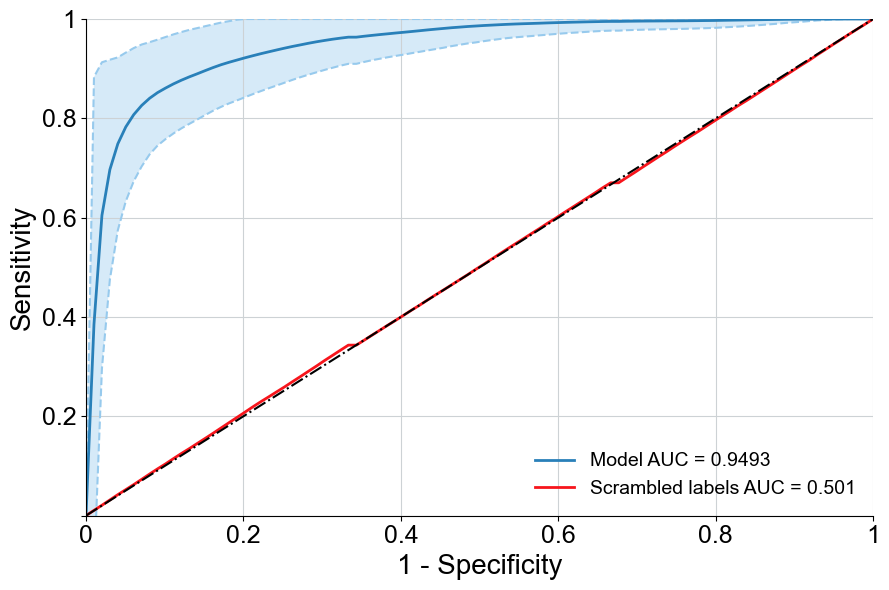

In [27]:
ml_plotting.plot_custom_roc_curve(lr_ROC_AUC, lr_ROC_chance, fname=None)

In [28]:
rf_fimp = bc.permutation_FIMP(data1, 'diagnosis', LogisticRegression(), params='default', test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [29]:
top_10p = rf_fimp.sort_values('mean', ascending=False).head(10)

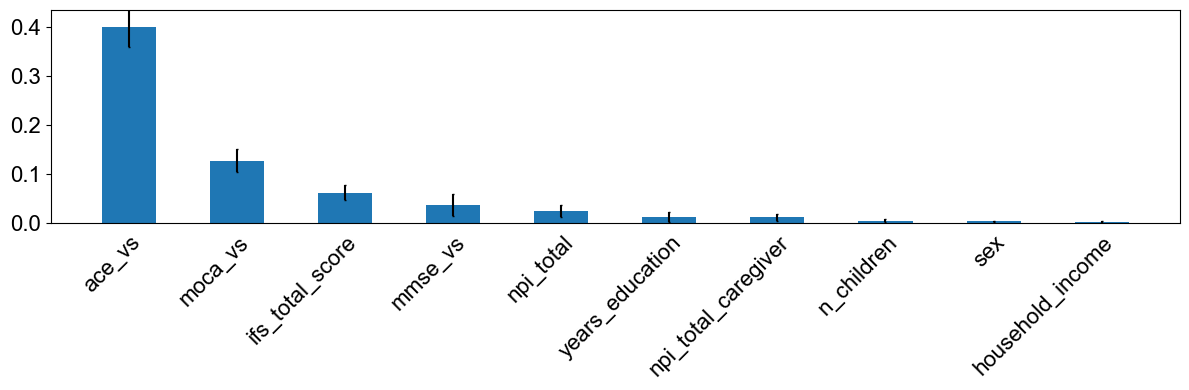

In [30]:
ml_plotting.plot_permutation_FIMP(top_10p, names='predictor', importances_col='mean', std_col='std')

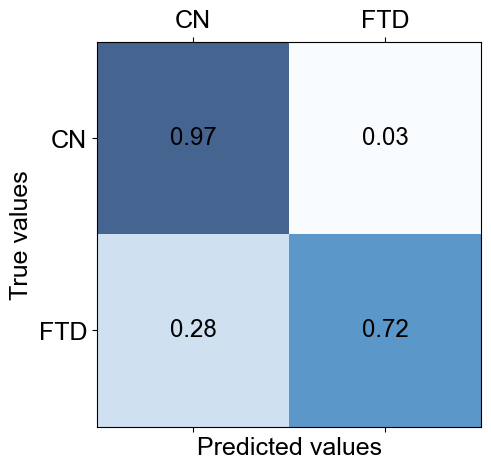

In [31]:
ml_plotting.plot_boostrap_CM(lr_CM, labels=['CN', 'FTD'],fname=None)

#### unseen data

In [32]:
X_train, y_train = data1.drop('diagnosis', axis=1), data1[['diagnosis']].values.ravel()
X_unseen, y_unseen = unseen_data[data1.columns].drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [33]:
scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaler=scaler.fit(X_train.iloc[:,:])
X_train.iloc[:,:] = scaler.transform(X_train.iloc[:,:])
X_unseen.iloc[:,:] = scaler.transform(X_unseen.iloc[:,:])

In [34]:
# predict & scores
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [35]:
unseen_df = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
# unseen_df.to_csv(path_res+ "/RandomForest/unseen.csv")

In [36]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.8507
Accuracy: 0.8987
Recall: 0.72
F1: 0.8182
Precision:0.9474


In [37]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{lr_res['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.8507
Bootstrping test ROC score: 	0.9493


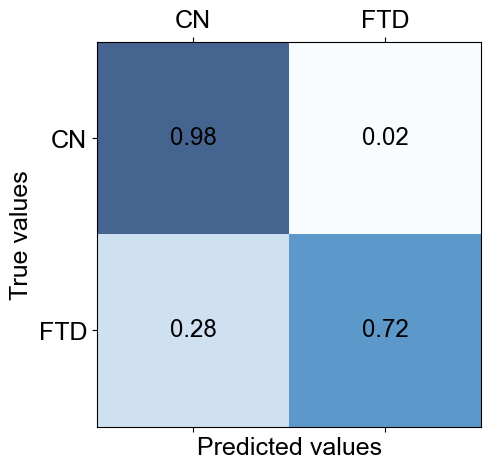

In [38]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['CN', 'FTD'])

### RF Model

#### Bootstrap 1

In [39]:
Model_res1, CI_df1, Model_res_r1, ROC_AUC1, CM1, ROC_chance1, empirical_p_value1 = bc.Bootstrap_tree_classifier(
    data1, 'diagnosis', RandomForestClassifier(), scaler='MM', params='default', test_size=.2, n_iter=n_iter, chance_model=True)

RandomForestClassifier()


Iterating: 100%|██████████████████| 5000/5000 [19:24<00:00,  4.30it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:19.400578514734903 minutes
empirical p-value: 0.0


In [40]:
path_res2

'/home/marcelo/GitRepos/Tesis/pred_results/2024-01-09/mean_res/RandomForest_FTD_vs_CN'

In [41]:
Model_res1.to_csv(path_res2+ "/Model_res1.csv", index=False)
Model_res1.mean()

Accuracy       0.908882
ROC_AUC        0.951264
Precision      0.889919
Recall         0.822509
Sensitivity    0.822509
Specificity    0.950269
F1             0.853501
Efron_pR2      0.662638
dtype: float64

In [42]:
print("%.4f" % Model_res1['ROC_AUC'].mean())

0.9513


In [43]:
CI_df1.to_csv(path_res2+ "/CI_df1.csv", index=False)
CI_df1

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.007977,0.005968,0.008676,0.010591,0.010591,0.006026,0.009801,0.013106


In [44]:
Model_res_r1.sort_values('Importance_mean', ascending=False).to_csv(path_res+ "/Model_res_r1.csv", index=False)
Model_res_r1.sort_values('Importance_mean', ascending=False).head(10)

,variables,Importance_mean,Importance_std
1,ace_vs,0.214894,0.023211
9,moca_vs,0.190159,0.022048
5,ifs_total_score,0.129017,0.013488
8,mmse_vs,0.121374,0.017366
11,npi_total,0.058965,0.007015
2,functionality,0.056575,0.006812
14,year_birth,0.047046,0.004061
15,years_education,0.038716,0.003601
7,mini_sea_total,0.037694,0.004514
12,npi_total_caregiver,0.035865,0.005253


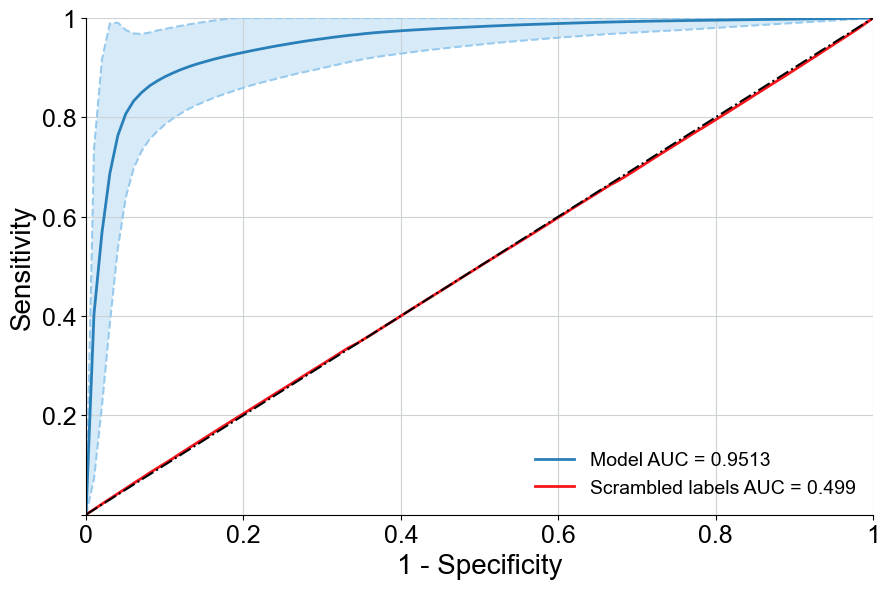

In [45]:
ml_plotting.plot_custom_roc_curve(ROC_AUC1, ROC_chance1, fname=path_res2+ "/ROC_AUC_curve1.png")

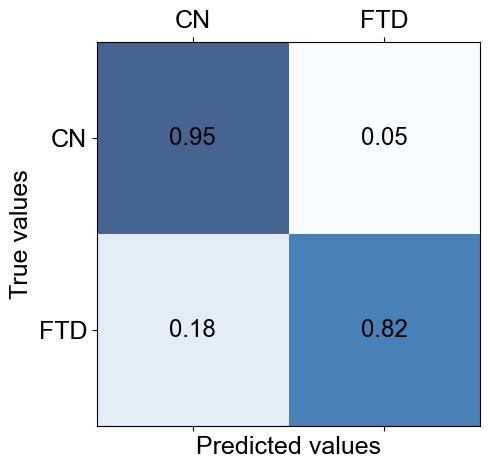

In [46]:
ml_plotting.plot_boostrap_CM(CM1, labels=['CN', 'FTD'],fname=path_res2+ "/CM1.png")

##### Permutation Feature importance

In [47]:
rf_fimp1 = bc.permutation_FIMP(data1, 'diagnosis', RandomForestClassifier(), params=rf_params1, test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [48]:
rf_fimp1.sort_values('mean', ascending=False).to_csv(path_res2+ "/rf_PFI1.csv")
top_10p1 = rf_fimp1.sort_values('mean', ascending=False).head(10)

In [49]:
top_10p1

,predictor,mean,std
3,ifs_total_score,0.018923,0.007029
8,moca_vs,0.014877,0.008517
9,ace_vs,0.013864,0.008529
7,mmse_vs,0.010321,0.007819
1,sex,0.005813,0.003716
10,functionality,0.005092,0.003308
6,npi_total_caregiver,0.004213,0.002930
5,npi_total,0.003360,0.003274
0,year_birth,0.002815,0.002430
2,years_education,0.002424,0.001854


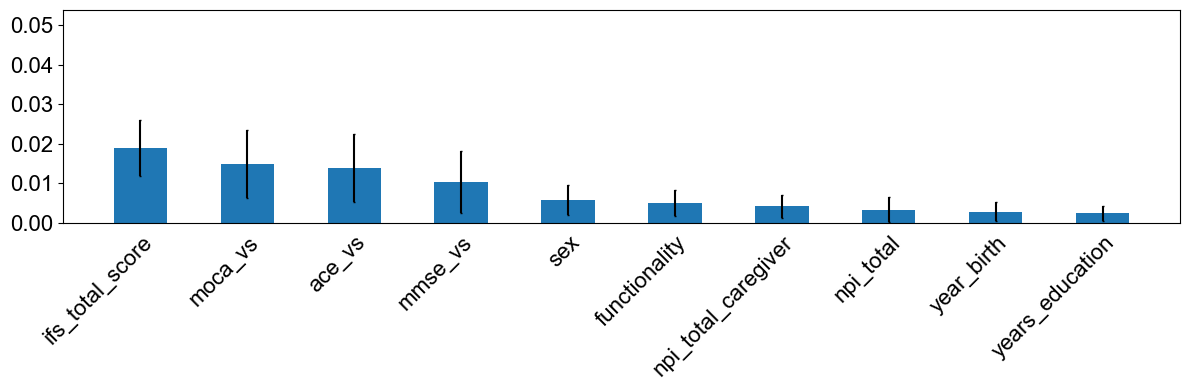

In [50]:
ml_plotting.plot_permutation_FIMP(top_10p1, names='predictor', importances_col='mean', std_col='std')

In [51]:
Model_res_r1.sort_values('Importance_mean', ascending=False).head()

,variables,Importance_mean,Importance_std
1,ace_vs,0.214894,0.023211
9,moca_vs,0.190159,0.022048
5,ifs_total_score,0.129017,0.013488
8,mmse_vs,0.121374,0.017366
11,npi_total,0.058965,0.007015


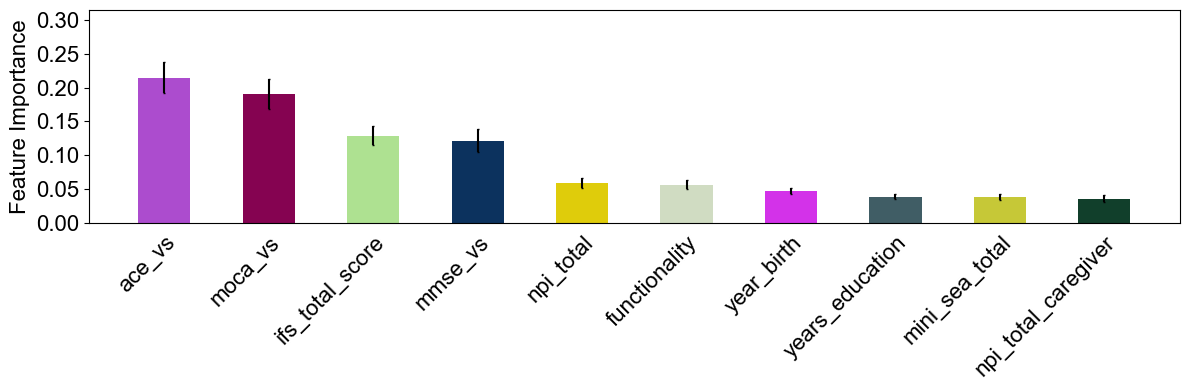

In [52]:
top_10_1 = Model_res_r1.sort_values('Importance_mean', ascending=False).head(10)
ml_plotting.plot_bootstrap_FIMP(top_10_1, 'variables','Importance_mean', 'Importance_std')

##### unseen data

In [53]:
X_train, y_train = data1.drop('diagnosis', axis=1), data1[['diagnosis']].values.ravel()
X_unseen, y_unseen = unseen_data[data1.columns].drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [54]:
scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaler=scaler.fit(X_train.iloc[:,:])
X_train.iloc[:,:] = scaler.transform(X_train.iloc[:,:])
X_unseen.iloc[:,:] = scaler.transform(X_unseen.iloc[:,:])

In [55]:
# predict & scores
rfc = RandomForestClassifier(**rf_params1)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [56]:
unseen_df1 = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df1.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
unseen_df1.to_csv(path_res+ "/unseen1.csv")

In [57]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.8181
Accuracy: 0.8101
Recall: 0.84
F1: 0.7368
Precision:0.6562


In [58]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{Model_res1['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.8181
Bootstrping test ROC score: 	0.9513


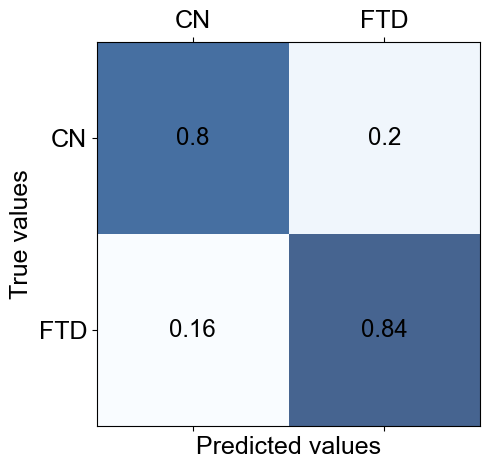

In [59]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['CN', 'FTD'],fname=path_res2+ "/CM_unseen1.png")

#### Shapley

In [60]:
# compute SHAP values
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_unseen, check_additivity=False)

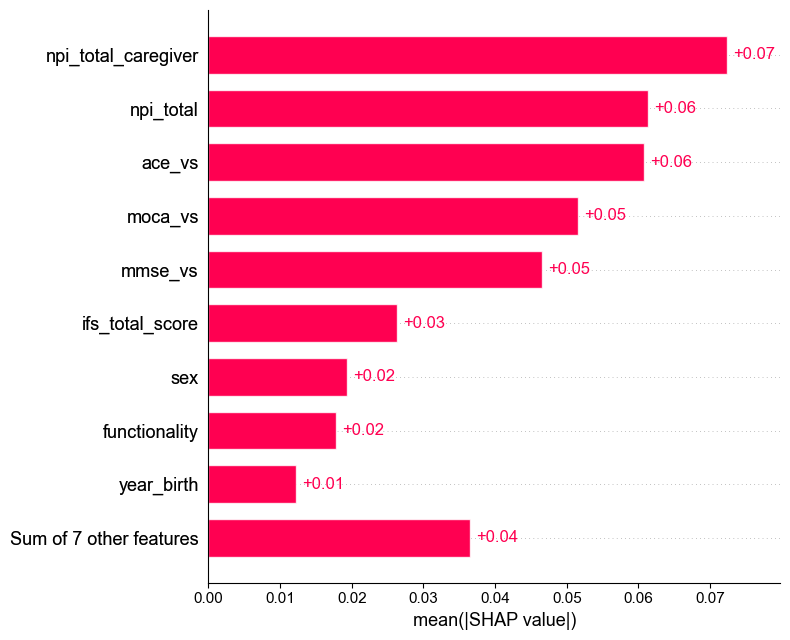

In [61]:
shap.plots.bar(shap_values[:,:,1])

#### Bootstrap 2

In [66]:
Model_res2, CI_df2, Model_res_r2, ROC_AUC2, CM2, ROC_chance2, empirical_p_value2 = bc.Bootstrap_tree_classifier(
    data2, 'diagnosis', RandomForestClassifier(), scaler='MM', params=rf_params2, test_size=.2, n_iter=n_iter, chance_model=True)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=6, max_features=1, min_samples_leaf=0.01,
                       min_samples_split=0.1892332525445738, n_estimators=1500,
                       n_jobs=-1)


Iterating: 100%|████████████████| 5000/5000 [3:57:31<00:00,  2.85s/it]

singular_matrix_errors (droped from results): 0
Eleapsed time:237.51697391668955 minutes
empirical p-value: 0.0


In [67]:
Model_res2.to_csv(path_res2+ "/Model_res2.csv", index=False)
Model_res2.mean()

Accuracy       0.874489
ROC_AUC        0.942409
Precision      0.783127
Recall         0.853535
Sensitivity    0.853535
Specificity    0.884529
F1             0.815236
Efron_pR2      0.575008
dtype: float64

In [68]:
print("%.4f" % Model_res2['ROC_AUC'].mean())

0.9424


In [69]:
CI_df2.to_csv(path_res2+ "/CI_df2.csv", index=False)
CI_df2

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.009183,0.006458,0.011423,0.009801,0.009801,0.008859,0.010758,0.013702


In [70]:
Model_res_r2.sort_values('Importance_mean', ascending=False).to_csv(path_res2+ "/Model_res_r2.csv", index=False)
Model_res_r2.sort_values('Importance_mean', ascending=False).head(10)

,variables,Importance_mean,Importance_std
0,ace_vs,0.224466,0.008965
5,moca_vs,0.223858,0.009036
4,mmse_vs,0.198506,0.008731
2,ifs_total_score,0.148533,0.008213
1,functionality,0.060501,0.004541
6,npi_total,0.058840,0.004420
7,npi_total_caregiver,0.045155,0.003565
3,mini_sea_total,0.040140,0.003523


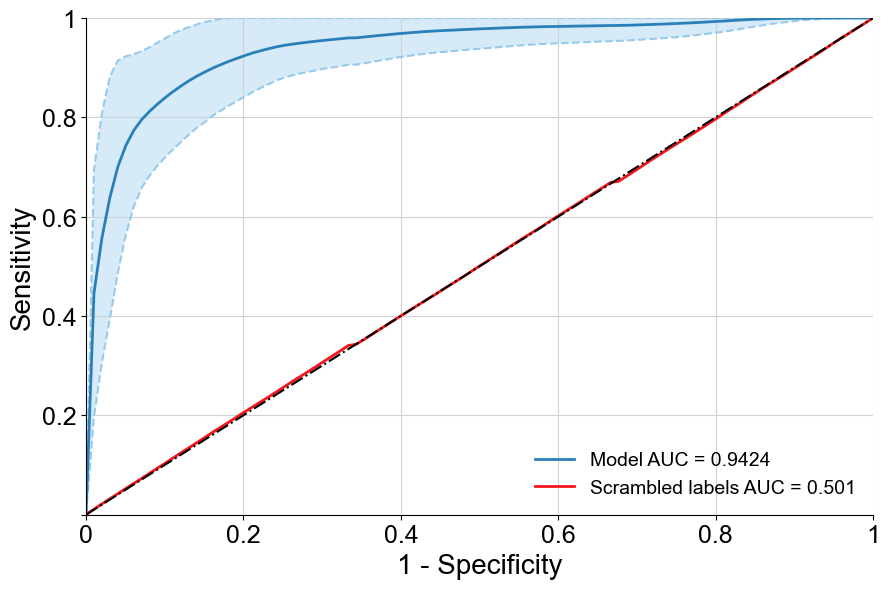

In [71]:
ml_plotting.plot_custom_roc_curve(ROC_AUC2, ROC_chance2, fname=path_res2+ "/ROC_AUC_curve2.png")

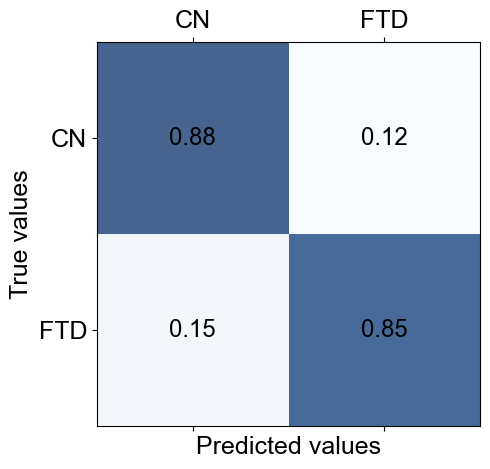

In [72]:
ml_plotting.plot_boostrap_CM(CM2, labels=['CN', 'FTD'],fname=path_res2+ "/CM2.png")

##### Permutation Feature importance

In [73]:
rf_fimp = bc.permutation_FIMP(data2, 'diagnosis', RandomForestClassifier(),
                              params=rf_params2, test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [74]:
rf_fimp.sort_values('mean', ascending=False).to_csv(path_res2+ "/rf_PFI2.csv")
top_10p2 = rf_fimp.sort_values('mean', ascending=False).head(10)

In [75]:
top_10p2

,predictor,mean,std
0,ifs_total_score,0.024054,0.007907
5,moca_vs,0.020116,0.010324
6,ace_vs,0.015741,0.009830
4,mmse_vs,0.013528,0.008634
3,npi_total_caregiver,0.009475,0.004655
7,functionality,0.008761,0.005124
2,npi_total,0.007837,0.003959
1,mini_sea_total,0.004436,0.002655


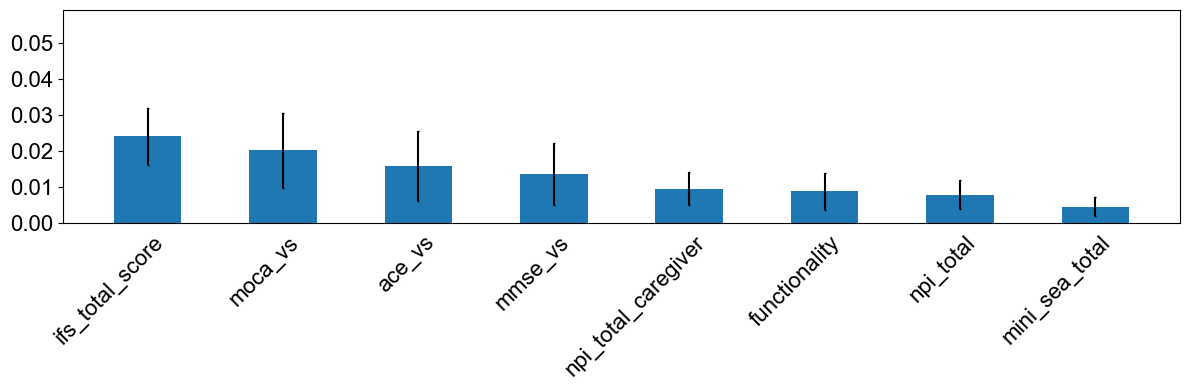

In [76]:
ml_plotting.plot_permutation_FIMP(top_10p2, names='predictor', importances_col='mean', std_col='std')

In [77]:
Model_res_r2.sort_values('Importance_mean', ascending=False).head()

,variables,Importance_mean,Importance_std
0,ace_vs,0.224466,0.008965
5,moca_vs,0.223858,0.009036
4,mmse_vs,0.198506,0.008731
2,ifs_total_score,0.148533,0.008213
1,functionality,0.060501,0.004541


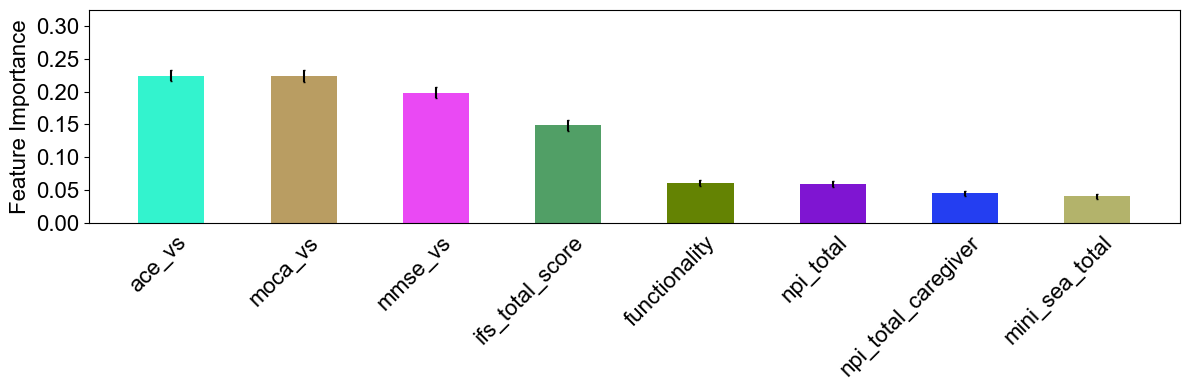

In [78]:
top_10_2 = Model_res_r2.sort_values('Importance_mean', ascending=False).head(10)
ml_plotting.plot_bootstrap_FIMP(top_10_2, 'variables','Importance_mean', 'Importance_std')

##### unseen data


In [79]:
X_train, y_train = data2.drop('diagnosis', axis=1), data2[['diagnosis']].values.ravel()
X_unseen, y_unseen = unseen_data[data2.columns].drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [80]:
scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaler=scaler.fit(X_train.iloc[:,:])
X_train.iloc[:,:] = scaler.transform(X_train.iloc[:,:])
X_unseen.iloc[:,:] = scaler.transform(X_unseen.iloc[:,:])

In [81]:
# predict & scores
rfc = RandomForestClassifier(**rf_params2)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [82]:
unseen_df2 = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df2.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
unseen_df2.to_csv(path_res2+ "/unseen2.csv")

In [83]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.8289
Accuracy: 0.8101
Recall: 0.88
F1: 0.7458
Precision:0.6471


In [84]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{Model_res2['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.8289
Bootstrping test ROC score: 	0.9424


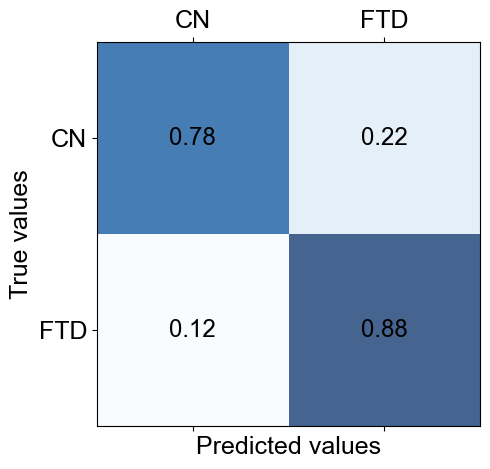

In [85]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['CN', 'FTD'],fname=path_res2+ "/CM_unseen2.png")

In [86]:
# compute SHAP values
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_unseen, check_additivity=False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


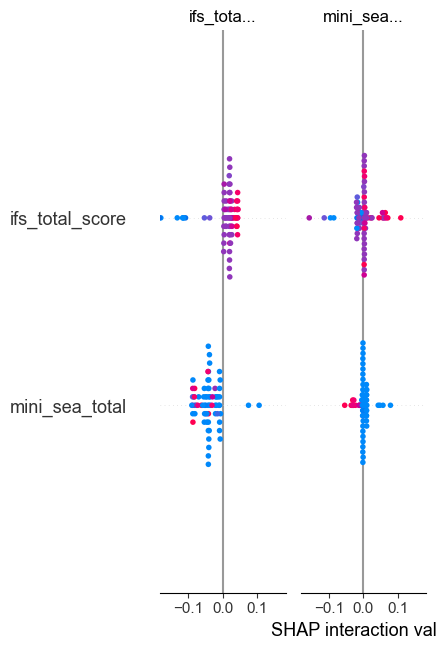

In [87]:
shap.summary_plot(shap_values, feature_names=X_train.columns)

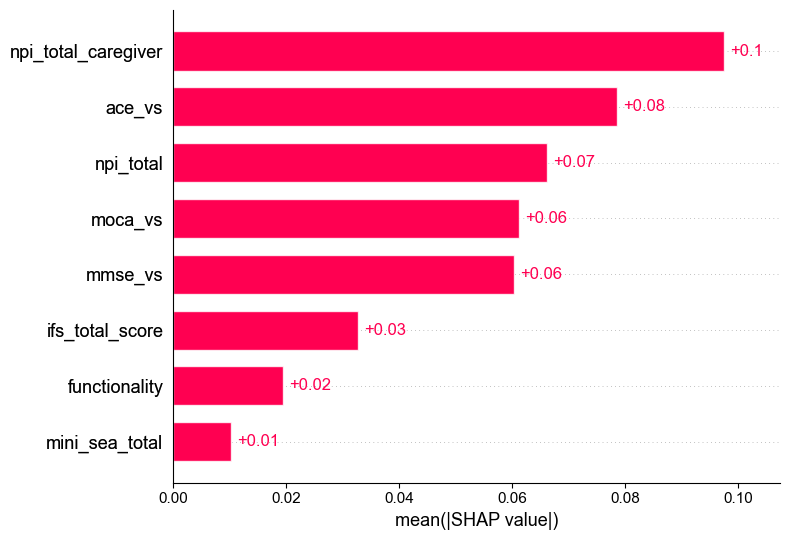

In [88]:
shap.plots.bar(shap_values[:,:,1])

#### Bootstrap 3

In [89]:
Model_res3, CI_df3, Model_res_r3, ROC_AUC3, CM3, ROC_chance3, empirical_p_value3 = bc.Bootstrap_tree_classifier(
    data3, 'diagnosis', RandomForestClassifier(), scaler='MM', params=rf_params3, test_size=.2, n_iter=n_iter, chance_model=True)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=14, max_features=1, min_samples_leaf=0.01,
                       min_samples_split=0.01, n_estimators=1500, n_jobs=-1)


Iterating: 100%|████████████████| 5000/5000 [3:54:43<00:00,  2.82s/it]

singular_matrix_errors (droped from results): 0
Eleapsed time:234.72959591945013 minutes
empirical p-value: 0.0


In [90]:
Model_res3.to_csv(path_res2+ "/Model_res3.csv", index=False)
Model_res3.mean()

Accuracy       0.898790
ROC_AUC        0.956489
Precision      0.870792
Recall         0.810048
Sensitivity    0.810048
Specificity    0.941312
F1             0.837877
Efron_pR2      0.493163
dtype: float64

In [91]:
print("%.4f" % Model_res3['ROC_AUC'].mean())

0.9565


In [92]:
CI_df3.to_csv(path_res2+ "/CI_df3.csv", index=False)
CI_df3

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.00836,0.005655,0.009298,0.010873,0.010873,0.006515,0.010216,0.013858


In [93]:
Model_res_r3.sort_values('Importance_mean', ascending=False).to_csv(path_res2+ "/Model_res_r3.csv", index=False)
Model_res_r3.sort_values('Importance_mean', ascending=False).head(10)

,variables,Importance_mean,Importance_std
1,cognition,0.318077,0.010191
5,ifs_total_score,0.194799,0.008315
2,functionality,0.089920,0.005762
9,npi_total,0.083425,0.005191
10,npi_total_caregiver,0.064293,0.004497
7,mini_sea_total,0.059506,0.004633
12,year_birth,0.050270,0.003769
13,years_education,0.043040,0.002823
11,sex,0.028112,0.004644
0,Job_status,0.017890,0.002320


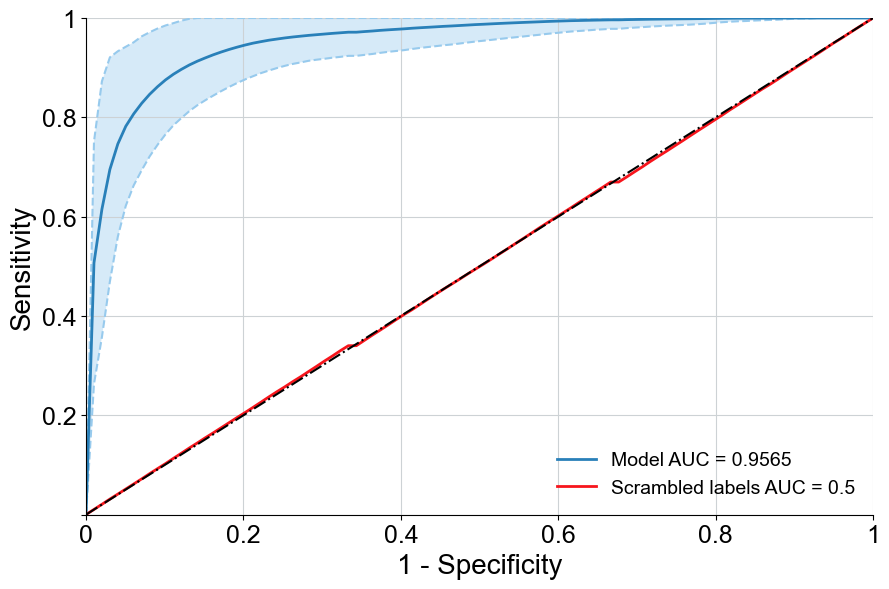

In [94]:
ml_plotting.plot_custom_roc_curve(ROC_AUC3, ROC_chance3, fname=path_res2+ "/ROC_AUC_curve3.png")

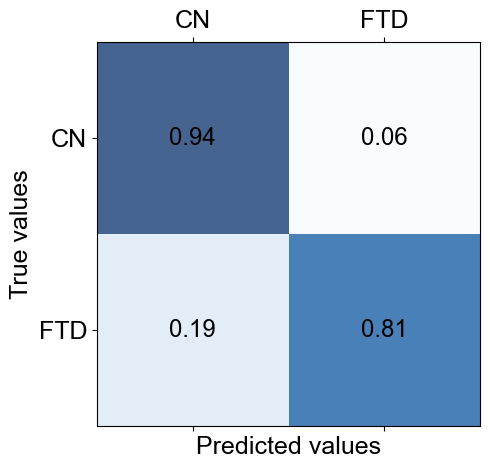

In [95]:
ml_plotting.plot_boostrap_CM(CM3, labels=['CN', 'FTD'],fname=path_res2+ "/CM3.png")

##### Permutation Feature importance

In [97]:
rf_fimp3 = bc.permutation_FIMP(data3, 'diagnosis', RandomForestClassifier(), params=rf_params3, test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [98]:
rf_fimp3.sort_values('mean', ascending=False).to_csv(path_res2+ "/rf_PFI3.csv")
top_10p3 = rf_fimp3.sort_values('mean', ascending=False).head(10)

In [99]:
top_10p3

,predictor,mean,std
7,cognition,0.121932,0.022343
3,ifs_total_score,0.035415,0.010047
8,functionality,0.010470,0.005392
1,sex,0.009934,0.005192
2,years_education,0.006647,0.002946
5,npi_total,0.006215,0.003914
6,npi_total_caregiver,0.006155,0.004703
0,year_birth,0.004534,0.003261
4,mini_sea_total,0.003844,0.002783
11,household_members,0.002791,0.000957


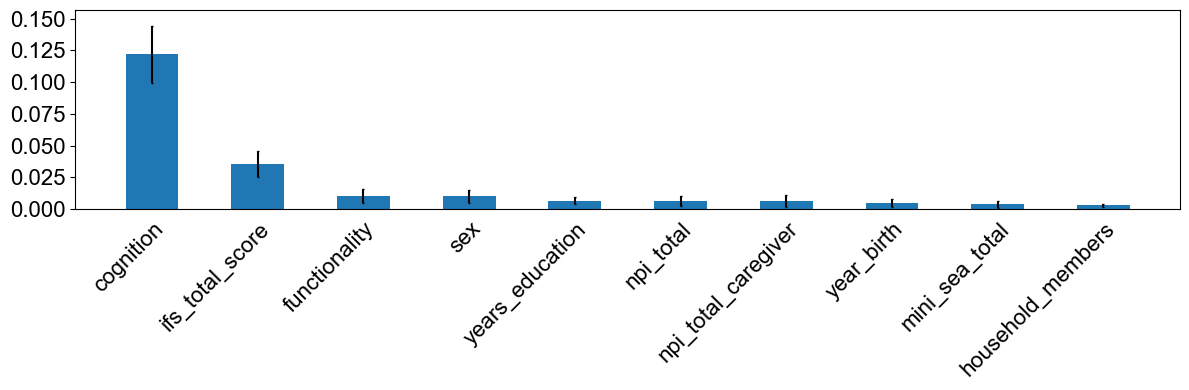

In [100]:
ml_plotting.plot_permutation_FIMP(top_10p3, names='predictor', importances_col='mean', std_col='std')

In [101]:
Model_res_r3.sort_values('Importance_mean', ascending=False).head()

,variables,Importance_mean,Importance_std
1,cognition,0.318077,0.010191
5,ifs_total_score,0.194799,0.008315
2,functionality,0.089920,0.005762
9,npi_total,0.083425,0.005191
10,npi_total_caregiver,0.064293,0.004497


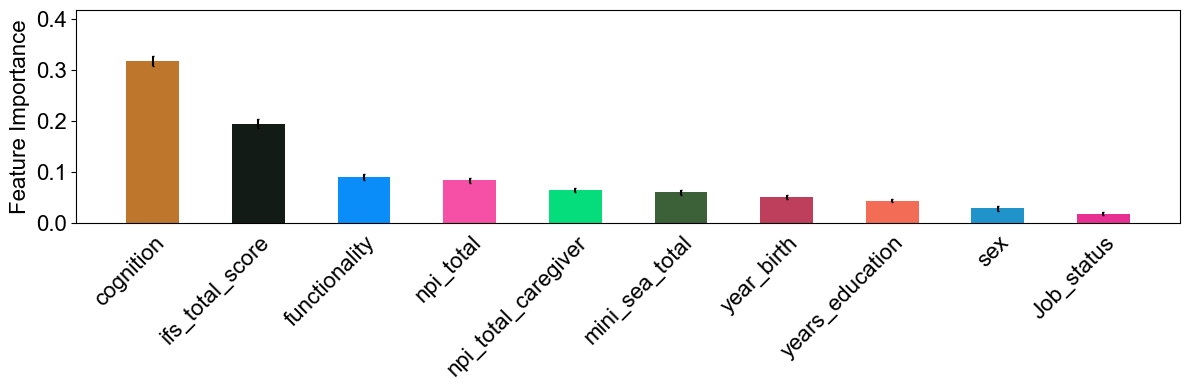

In [102]:
top_10_3 = Model_res_r3.sort_values('Importance_mean', ascending=False).head(10)
ml_plotting.plot_bootstrap_FIMP(top_10_3, 'variables','Importance_mean', 'Importance_std')

##### unseen data


In [103]:
X_train, y_train = data3.drop('diagnosis', axis=1), data[['diagnosis']].values.ravel()
X_unseen, y_unseen = unseen_data[data3.columns].drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [104]:
scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaler=scaler.fit(X_train.iloc[:,:])
X_train.iloc[:,:] = scaler.transform(X_train.iloc[:,:])
X_unseen.iloc[:,:] = scaler.transform(X_unseen.iloc[:,:])

In [105]:
# predict & scores
rfc = RandomForestClassifier(**rf_params3)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [106]:
unseen_df3 = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df3.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
unseen_df3.to_csv(path_res2+ "/unseen3.csv")

In [107]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.767
Accuracy: 0.6962
Recall: 0.96
F1: 0.6667
Precision:0.5106


In [108]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{Model_res3['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.767
Bootstrping test ROC score: 	0.9565


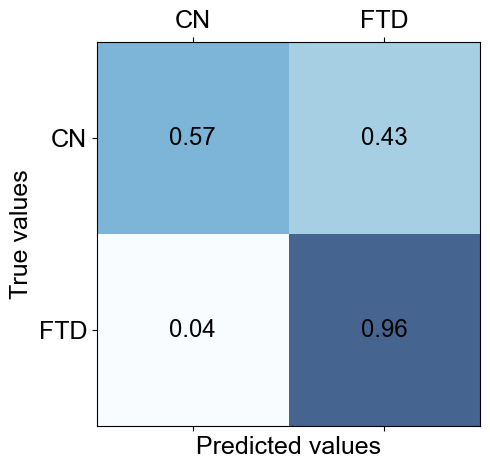

In [109]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['CN', 'FTD'],fname=path_res2+ "/CM_unseen3.png")

In [110]:
# compute SHAP values
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_unseen, check_additivity=False)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


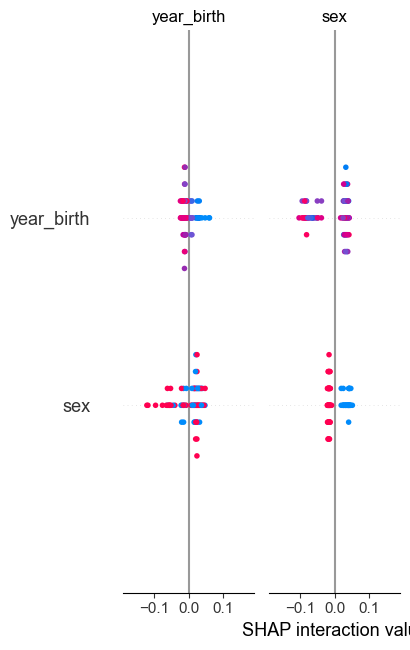

In [111]:
shap.summary_plot(shap_values, feature_names=X_train.columns)

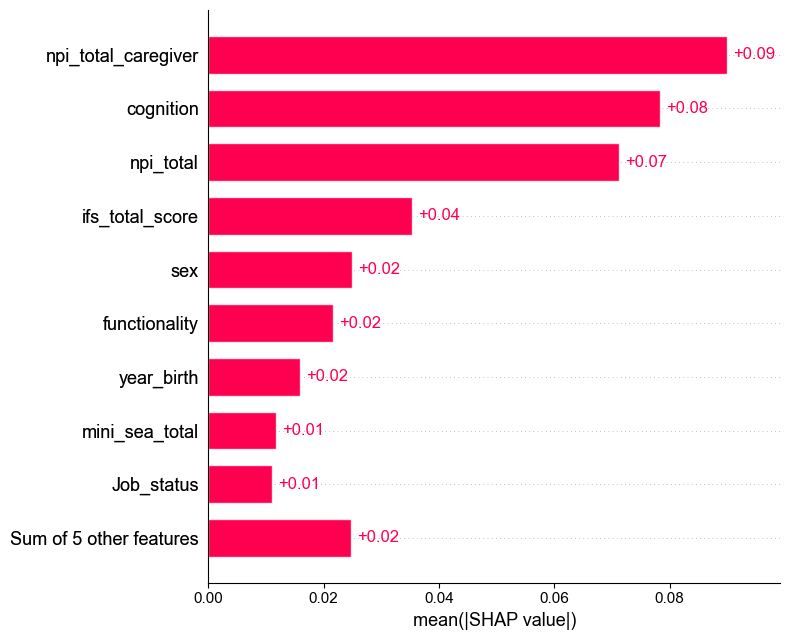

In [112]:
shap.plots.bar(shap_values[:,:,1])

### Sequential feature selector

#### RF

In [113]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [114]:
n_splits = 3
cv = StratifiedKFold(n_splits=n_splits)

In [115]:
rf_params3['max_features'] =1

In [116]:
sfs_rfc = SFS(RandomForestClassifier(**rf_params3), 
           k_features='best', 
           forward=True, 
           floating=False, 
           verbose=1,
           cv=cv, n_jobs =-1)

In [117]:
sfs_rfc = sfs_rfc.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   10.0s finished
Features: 1/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:   10.4s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:   10.5s finished
Features: 2/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    9.4s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    9.6s finished
Features: 3/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    8.8s remaining:   15.4s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    9.0s finished
Features: 4/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 

In [118]:
sfs_rf = pd.DataFrame.from_dict(sfs_rfc.get_metric_dict()).T

In [119]:
sfs_rf

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(7,)","[0.826271186440678, 0.851063829787234, 0.86382...",0.847055,"(cognition,)",0.03509,0.015593,0.011026
2,"(3, 7)","[0.8771186440677966, 0.8978723404255319, 0.872...",0.882444,"(ifs_total_score, cognition)",0.02494,0.011083,0.007837
3,"(3, 7, 8)","[0.8813559322033898, 0.9106382978723404, 0.885...",0.892367,"(ifs_total_score, cognition, functionality)",0.029277,0.01301,0.0092
4,"(3, 6, 7, 8)","[0.8898305084745762, 0.9234042553191489, 0.872...",0.895192,"(ifs_total_score, npi_total_caregiver, cogniti...",0.047681,0.021189,0.014983
5,"(3, 5, 6, 7, 8)","[0.8940677966101694, 0.9191489361702128, 0.889...",0.900859,"(ifs_total_score, npi_total, npi_total_caregiv...",0.029422,0.013075,0.009245
6,"(2, 3, 5, 6, 7, 8)","[0.8983050847457628, 0.9191489361702128, 0.889...",0.902272,"(years_education, ifs_total_score, npi_total, ...",0.028084,0.01248,0.008825
7,"(2, 3, 5, 6, 7, 8, 9)","[0.8983050847457628, 0.9191489361702128, 0.893...",0.90369,"(years_education, ifs_total_score, npi_total, ...",0.024972,0.011097,0.007847
8,"(2, 3, 4, 5, 6, 7, 8, 9)","[0.8983050847457628, 0.9191489361702128, 0.897...",0.905109,"(years_education, ifs_total_score, mini_sea_to...",0.022345,0.009929,0.007021
9,"(2, 3, 4, 5, 6, 7, 8, 9, 13)","[0.8983050847457628, 0.9234042553191489, 0.893...",0.905109,"(years_education, ifs_total_score, mini_sea_to...",0.029429,0.013078,0.009247
10,"(0, 2, 3, 4, 5, 6, 7, 8, 9, 13)","[0.8983050847457628, 0.9234042553191489, 0.897...",0.906527,"(year_birth, years_education, ifs_total_score,...",0.026858,0.011935,0.008439


In [120]:
sfs_rf.loc[[5],:]

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
5,"(3, 5, 6, 7, 8)","[0.8940677966101694, 0.9191489361702128, 0.889...",0.900859,"(ifs_total_score, npi_total, npi_total_caregiv...",0.029422,0.013075,0.009245


In [121]:
# 5, 13
sfs_rf_features = list(sfs_rf.loc[5, 'feature_names'])

In [122]:
sfs_rf_features

['ifs_total_score',
 'npi_total',
 'npi_total_caregiver',
 'cognition',
 'functionality']

In [123]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

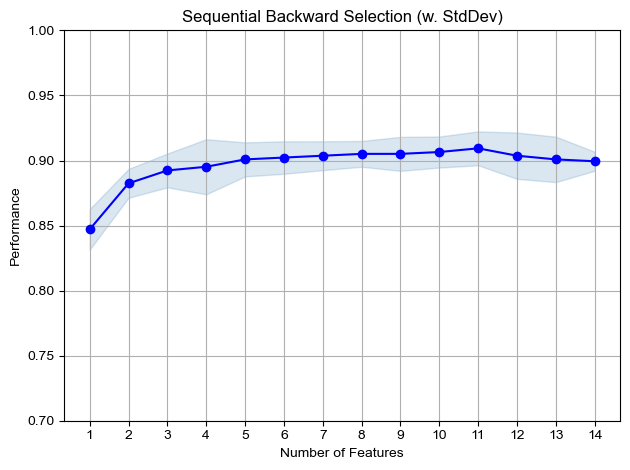

In [124]:
fig1 = plot_sfs(sfs_rfc.get_metric_dict(), kind='std_dev')


plt.ylim([0.7, 1])
# plt.figure(figsize=(13, 3))
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

### Shapley

In [125]:
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_unseen, check_additivity=False)

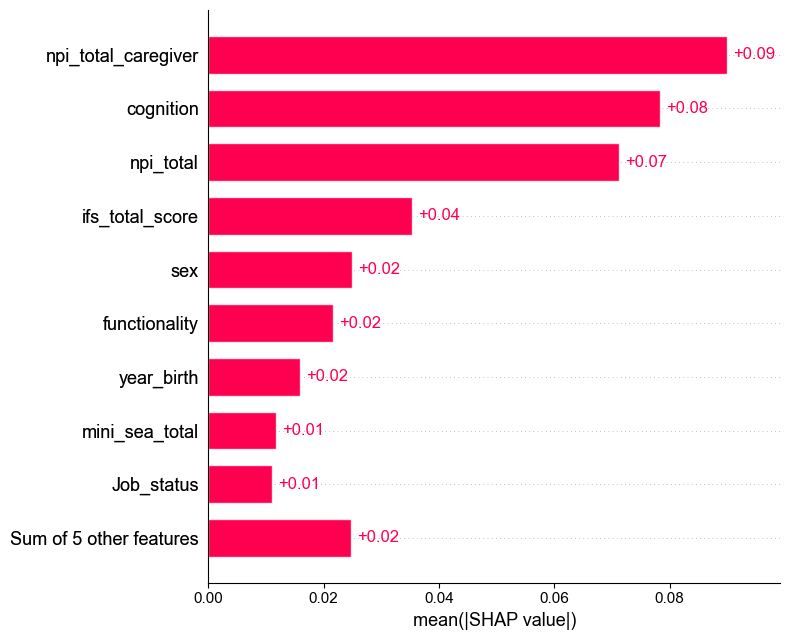

In [126]:
shap.plots.bar(shap_values[:,:,1])